# Exercise 2

In [1]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Bootstrap - Reconstructing variance
According to hastie et al. and the lecture notes (week 37) Bootstrap, by randomly sampling from the dataset, can estimate the uncertainty in the parameters. In Hastie et al this is refered to as the monte-carlo estimate of variance. In the following I will try to estimate variance in parameteres beta using bootstrap resampling and compare the results to the analtical expresiion for variance:

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from franke_function import FrankeFunction as Fr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tqdm # progressbar

#sk-learn linear regression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

# my own library
from regression import OLS


x = np.linspace(0, 1, 50) 
y = np.linspace(0, 1, 50)
x, y = np.meshgrid(x, y)

poly = 30
n_bootstraps = 50
MSE_test_list = [] 
MSE_train_list = []
MSE_test_list_skl = [] 
MSE_train_list_skl = []
betas_list = []
var_betas_list = []
# an attempt to study irreducible noise

noise = np.random.randn(x.shape[0], x.shape[1])
z = Fr(x, y) + noise*0.3

# Standardization: Running without scaling causes more variance in beta values. 
x_cent =  ((x - np.mean(x))/np.sqrt(np.var(x))).reshape(-1, 1)  #x.reshape(-1, 1)# 
y_cent =  ((y - np.mean(y))/np.sqrt(np.var(y))).reshape(-1, 1)  #y.reshape(-1, 1)#
z_cent =  ((z - np.mean(z))/np.sqrt(np.var(z))).reshape(-1, 1) #z.reshape(-1, 1)

xy_cent_train, xy_cent_test, z_cent_train, z_cent_test = train_test_split(np.hstack([x_cent, y_cent]),
                                                                        z_cent, test_size=0.2)
for n in tqdm.tqdm(range(n_bootstraps)): 
    #print("Bootstrap number: " + str(n+1) + '/' + str(n_bootstraps))
    MSE_test = []
    MSE_train = []
    MSE_test_skl = []
    MSE_train_skl = []
    beta = np.zeros([poly, int((poly + 1)*(poly + 2)/2)]) 
    var_beta = np.zeros([poly, int((poly + 1)*(poly + 2)/2)]) 
    
    #draw n samples from train set
    n = z_cent_train.size 
    samples_nr = np.random.randint(0,n,n)
    xy_samp = xy_cent_train[samples_nr, :]
    z_samp = z_cent_train[samples_nr, :]
    
    # polynomial fit to bootstrap samples
    for poly_deg in range(1, poly + 1):
        # fit skl and my own model, for camparison
        model = OLS(xy_samp[:, 0].ravel(), xy_samp[:, 1].ravel(), z_samp.ravel(), poly_deg, design = 'o')#skl
        model_skl = make_pipeline(PolynomialFeatures(degree=poly_deg), LinearRegression(fit_intercept=False))
        
        #calculate interesting numbers
        MSE_test.append(model.MSE(xy_cent_test[:, 0], xy_cent_test[:, 1], z_cent_test.ravel())) 
        MSE_train.append(model.MSE(xy_samp[:, 0], xy_samp[:, 1], z_samp.ravel())) # train set

        z_pred_train_skl = model_skl.fit(xy_samp, z_samp.reshape(-1, 1)).predict(xy_samp).ravel()
        z_pred_test_skl = model_skl.fit(xy_samp, z_samp.reshape(-1, 1)).predict(xy_cent_test).ravel()
        MSE_test_skl.append(np.mean((z_cent_test.ravel() - z_pred_test_skl.ravel())**2))
        MSE_train_skl.append(np.mean((z_samp.ravel() - z_pred_train_skl.ravel())**2))
        
        
        #store estimated beta values
        beta[poly_deg-1, 0: int((poly_deg + 1)*(poly_deg + 2)/2)] = np.array(model.beta_OLS.ravel()) 
        beta[poly_deg-1, int((poly_deg + 1)*(poly_deg + 2)/2):] = np.nan
        
        #store analytical beta variance
        var_beta[poly_deg-1, 0: int((poly_deg + 1)*(poly_deg + 2)/2)] = np.array(
            model.var_beta(xy_samp[:, 0], xy_samp[:, 1], z_samp)) # analytical variance train betas
        var_beta[poly_deg-1, int((poly_deg + 1)*(poly_deg + 2)/2):] = np.nan

    # store all values for averaging
    MSE_test_list.append(MSE_test) 
    MSE_train_list.append(MSE_train)
    MSE_test_list_skl.append(MSE_test_skl)
    MSE_train_list_skl.append(MSE_train_skl)
    betas_list.append(beta) 
    var_betas_list.append(var_beta)
    
MSE_test_list = np.array(MSE_test_list)
MSE_train_list = np.array(MSE_train_list)
MSE_test_list_skl = np.array(MSE_test_list_skl)
MSE_train_list_skl = np.array(MSE_train_list_skl)
betas_list = np.array(betas_list, dtype=object)
var_betas_list = np.array(var_betas_list, dtype=object)

#study average values
MSE_test_average = np.mean(MSE_test_list, axis=0) 
MSE_train_average = np.mean(MSE_train_list, axis=0)
MSE_test_average_skl = np.mean(MSE_test_list_skl, axis=0)
MSE_train_average_skl = np.mean(MSE_train_list_skl, axis=0)
mean_betas = np.mean(betas_list, axis=0) 
var_betas = np.var(betas_list, axis=0)
var_betas_analytical = np.mean(var_betas_list, axis=0)


100%|██████████| 50/50 [03:25<00:00,  4.10s/it]


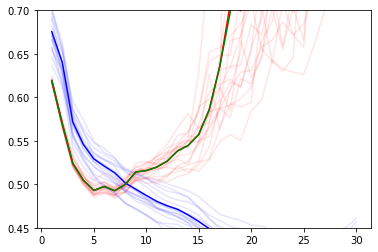

In [13]:
for i in range(0, len(MSE_test_list), 3): # every thrid bootstrap
    plt.plot(range(1, len(MSE_test)+1), MSE_test_list[i], 'r', alpha=0.1) 
    plt.plot(range(1, len(MSE_test)+1), MSE_train_list[i], 'b', alpha=0.1) 

plt.plot(range(1, len(MSE_test)+1), MSE_test_average, 'r')
plt.plot(range(1, len(MSE_train)+1), MSE_train_average, 'b')
plt.plot(range(1, len(MSE_train)+1), MSE_test_average_skl, 'g')
#plt.plot(range(1, len(variance_avrg)+1), variance_avrg, 'g')

plt.ylim(0.45, 0.7)
plt.show()

From the plot above we can observe that my implemented OLS algorithm behaves somewhat similar to the Scikit-learn OLS (the tick green line is sklearn). For polynomials above degree 23 the two OLS implementations seems to diverge more and more from each other. This could be due to numerical roundoff errors, in that case probably in my own implementation. 
- I implemented the design matrix assuming a different order of polynomials [1, x, x^2 ...] instead of skl assumed order: [1, x, y, x^2 ... ]. As a test i implemented an option to send the keyword 'skl' to the regression class, causing a different order of the polynomials in the design matrix. I cant seem to find any patters indicationg that running my code with skl order changes the solution.
- SKL is probably more correct than my implementation taking other factors into concideration. Still, I will continue to use my implemented verison of OLS throughout this project, keeping it mind that numerical errors arrise for large polynomials (23++ with noise 0,3) 
- The number of bootstraps does not (significantly at least) affect the polynomial degree for which skl and my own MSE starts to diverge from eatchother
- Not scaling data (this accounts for x, y AND z data) causes more variance in beta values. My own implementation vs. skl also diverges from each other sooner. An explanaiton for this could be that polynomials are good at estimating "humps" in origo, but estimating "humps" far away from origo requires an massive effort of betas. 

In [8]:
mean_betas[4]

array([-0.14127258458691697, -0.3643228978961299, 1.4395505544381337,
       -0.18963128138455687, -1.6213310753529988, 0.03826513889878495,
       -2.033538462055345, 0.9629570013557118, -0.34743393500689945,
       -0.5733664987331141, 0.9816334958787318, 0.31047819425314394,
       -1.5160710049009876, 0.046994903667391306, 0.8632636808172736,
       3.041969065933639, -0.09478349025345566, -0.6291868006109437,
       -0.5688302051332234, 0.7556983511322964, -1.4317870764650964, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
    

# Plot and compare beta with results from ex1

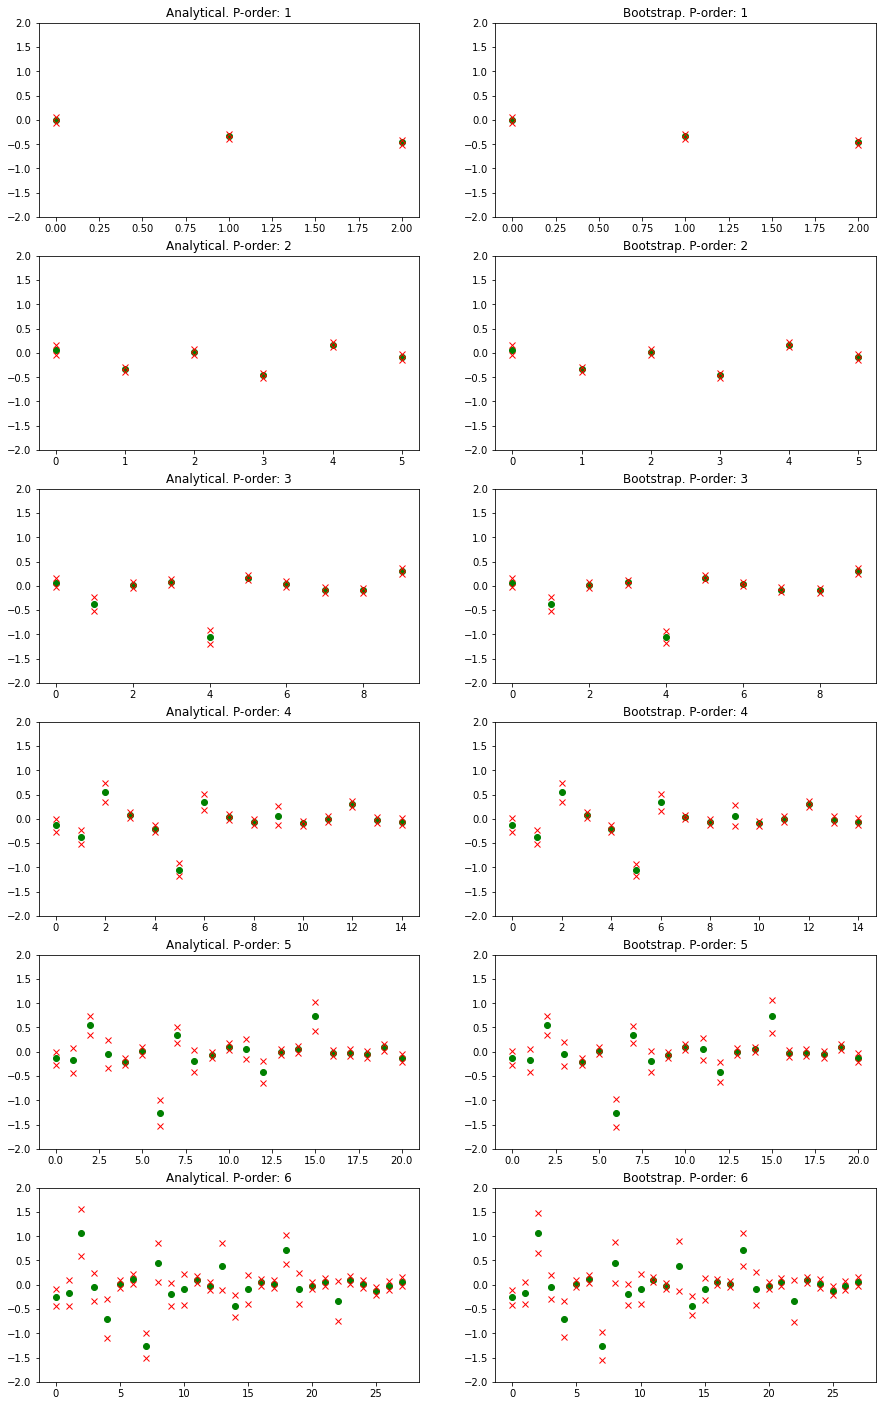

In [19]:
import matplotlib.pyplot as plt
n_polynom = 6 # plot polynoms up to n_polynom order
sigma = 1 # plot two sigma uncertainty
fig, axs = plt.subplots(n_polynom, 2, figsize=(15, 25), facecolor='w', edgecolor='k')
#axs = axs.ravel()

sigma = 3
for polynom_nr in range(n_polynom):
    for beta_nr_i in range((polynom_nr+2)**2): # extracts first beta values! 
        axs[polynom_nr, 1].plot(beta_nr_i, mean_betas[polynom_nr][beta_nr_i], 'go') #plot middle beta
        axs[polynom_nr, 1].plot(beta_nr_i, mean_betas[polynom_nr][beta_nr_i] - sigma*np.sqrt(var_betas[
            polynom_nr][beta_nr_i]), 'rx') #plot middle beta
        axs[polynom_nr, 1].plot(beta_nr_i, mean_betas[polynom_nr][beta_nr_i] + sigma*np.sqrt(var_betas[
            polynom_nr][beta_nr_i]), 'rx') #plot middle beta

        axs[polynom_nr, 0].plot(beta_nr_i, mean_betas[polynom_nr][beta_nr_i], 'go') #plot middle beta
        axs[polynom_nr, 0].plot(beta_nr_i, mean_betas[polynom_nr][beta_nr_i] - sigma*np.sqrt(var_betas_analytical[
            polynom_nr][beta_nr_i]), 'rx') #plot middle beta
        axs[polynom_nr, 0].plot(beta_nr_i, mean_betas[polynom_nr][beta_nr_i] + sigma*np.sqrt(var_betas_analytical[
            polynom_nr][beta_nr_i]), 'rx') #plot middle beta

    axs[polynom_nr, 1].set_title('Bootstrap. P-order: ' + str(polynom_nr + 1))
    axs[polynom_nr, 1].set_ylim([-2, 2])
    axs[polynom_nr, 0].set_title('Analytical. P-order: ' + str(polynom_nr + 1))
    axs[polynom_nr, 0].set_ylim([-2, 2])
    
plt.show()

Setting n_bootstraps too low (n_bootstraps = 10) causes bootstrap variance estimate to not look like the analyticl expression. Setting n_bootstraps equal to 50 or higher seems to be enought to estimate variance in beta, at least up to polynomial degree 5. 